In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from IPython.display import Audio
import constants


In [36]:
DATA = pd.read_csv(constants.DATA, delimiter='\t')
DATA.tail()

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
906948,dc1e379757b50ea57ba0d86fa2cfbc2e,wavs/dc1e379757b50ea57ba0d86fa2cfbc2e.wav,4.159625,sad,2.0,cff125aa5153b7677dd28377337dcd2f,индийские фильмы индийские,sad,037539580d1e28a834912088be1b81b0
906949,d923edeb05adcebc215d9ae9d9655a0a,wavs/d923edeb05adcebc215d9ae9d9655a0a.wav,3.784438,neutral,2.0,cff125aa5153b7677dd28377337dcd2f,сериал метро,sad,795e545977414fa4f915249f451d24f8
906950,b5dd4c4fd8f9e1f6f2b77041e0a69fe4,wavs/b5dd4c4fd8f9e1f6f2b77041e0a69fe4.wav,2.722938,neutral,2.0,6a059476b07f0467b9474fc47537784e,смотреть ужасы про крыс,sad,49fe520fd45da95b7c575e3db07846d2
906951,593277832bed252bf5f321223d5d08f4,wavs/593277832bed252bf5f321223d5d08f4.wav,3.349000,neutral,NaN,6a059476b07f0467b9474fc47537784e,мороженщик в реальной жизни,neutral,4de2287e6b082e4f652050eba71d21b2
906952,875a934947d3212d76afe782c4e2ca09,wavs/875a934947d3212d76afe782c4e2ca09.wav,3.320000,angry,4.0,6a059476b07f0467b9474fc47537784e,NaN,NaN,NaN


In [37]:
def create_tsv_file_for_N_records(value: int):
    # Чтение данных из CSV файла
    data = pd.read_csv(constants.DATA, delimiter='\t')

    # Равное количество записей для каждой эмоции
    emotions = ['angry', 'neutral', 'sad', 'positive']
    records_per_emotion = value // len(emotions)

    # Пустой DataFrame для хранения выбранных записей
    selected_data = pd.DataFrame(columns=data.columns)

    # Выбор равного количества записей для каждой эмоции
    for emo in emotions:
        emo_data = data[(data['annotator_emo'] == emo) & (data['speaker_emo'] == emo)].head(records_per_emotion)
        selected_data = pd.concat([selected_data, emo_data])

    # Путь для сохранения нового файла
    raw_crowd_train = f"C:\\Users\\s5pen\\DataSpellProjects\\SER\\data_tcv\\raw_crowd_train_{value}.tsv"

    # Сохранение выбранных данных в новом TSV файле
    selected_data.to_csv(raw_crowd_train, sep='\t', index=False)


In [38]:
# Создание нового файла на 4 строки и уникальных эмоции
create_tsv_file_for_N_records(4)

In [39]:
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, emotion):
    # Преобразование аудиоданных в краткосрочное преобразование Фурье (STFT)
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()
    
def create_audio_display(data):
    display(Audio(data))


In [40]:
data_4 = pd.read_csv("C:\\Users\\s5pen\\DataSpellProjects\\SER\\data_tcv\\raw_crowd_train_4.tsv", delimiter='\t')
data_4

,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,475e76f77ac1ed7cabafca740b15b32a,wavs/475e76f77ac1ed7cabafca740b15b32a.wav,2.453,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry,fa136da095807ea6cd18dd6e2f58d4d0
1,2f9438ef68395c70a8714dc373a49d11,wavs/2f9438ef68395c70a8714dc373a49d11.wav,4.640,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral,3d436884cbbe25373914f8768de494f7
2,fb44b08978c2254dca5c03b3f8b6f951,wavs/fb44b08978c2254dca5c03b3f8b6f951.wav,4.880,sad,NaN,858305a5450b7bd1288ba0053b1cd1c1,ну да плохое,sad,037af49d121127532aa7172f71b4ce19
3,ed5a0505897b5fd7fdd36e75e336e746,wavs/ed5a0505897b5fd7fdd36e75e336e746.wav,5.260,positive,NaN,858305a5450b7bd1288ba0053b1cd1c1,анекдот мне расскажешь,positive,a1863537906ea4335372883d6a9261f7


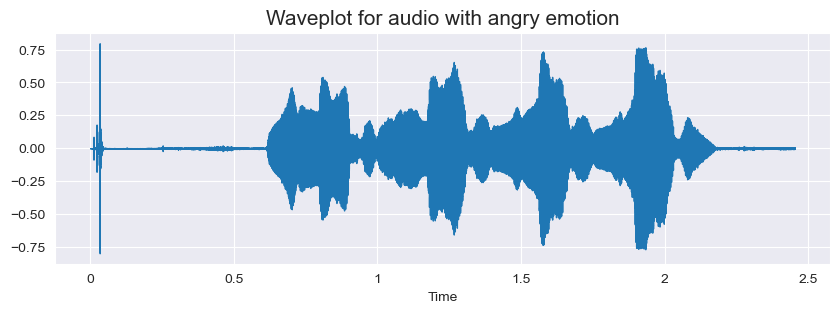

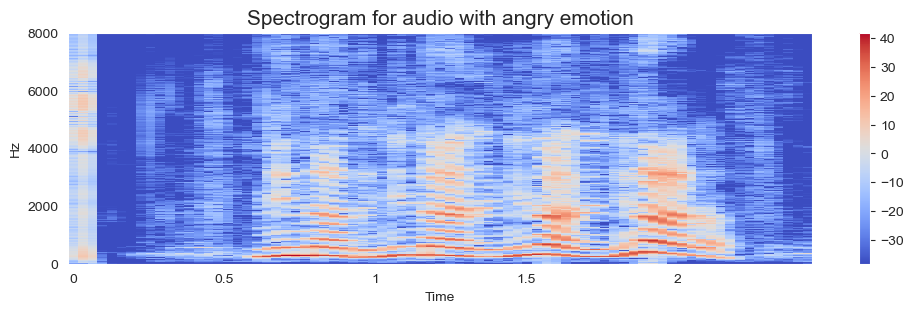

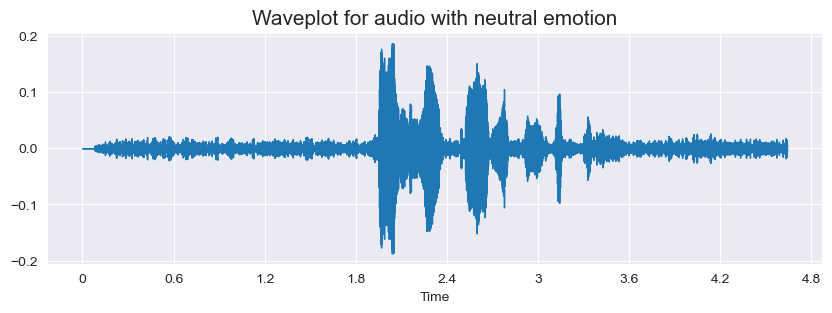

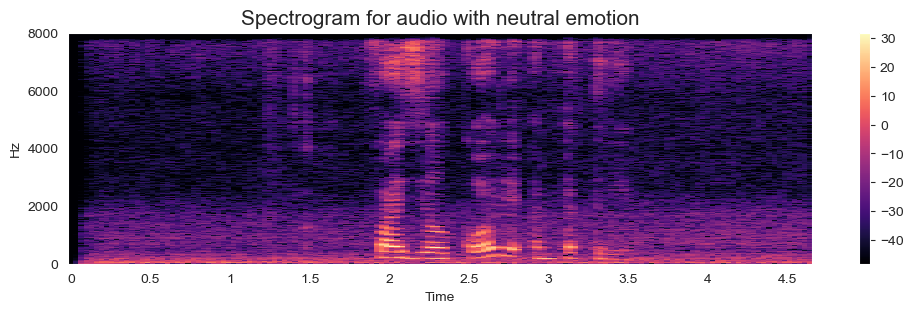

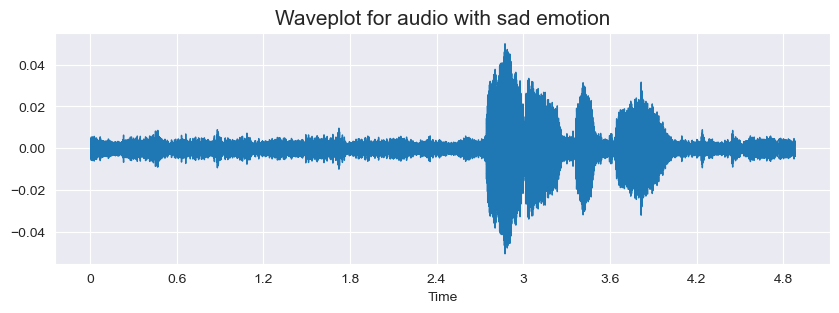

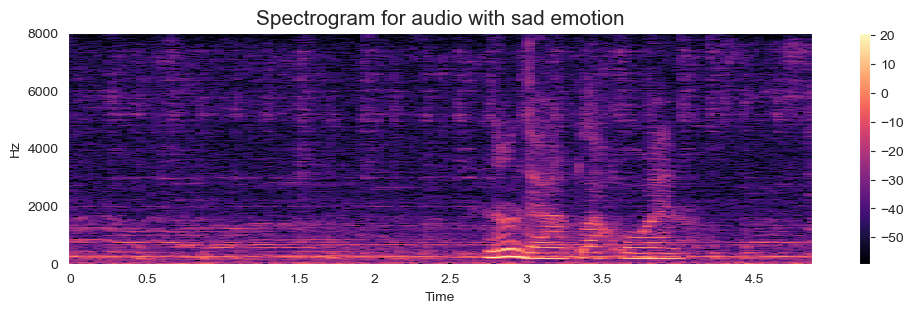

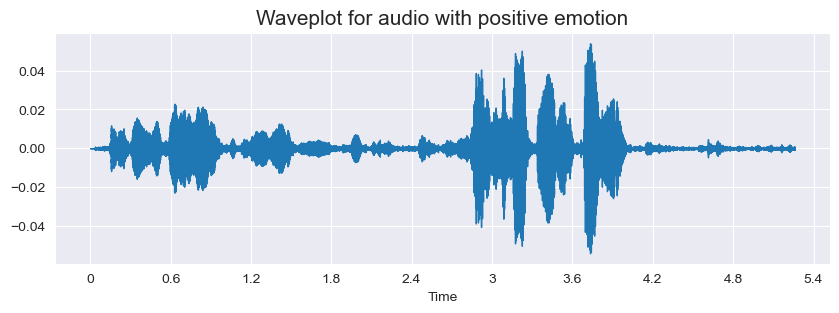

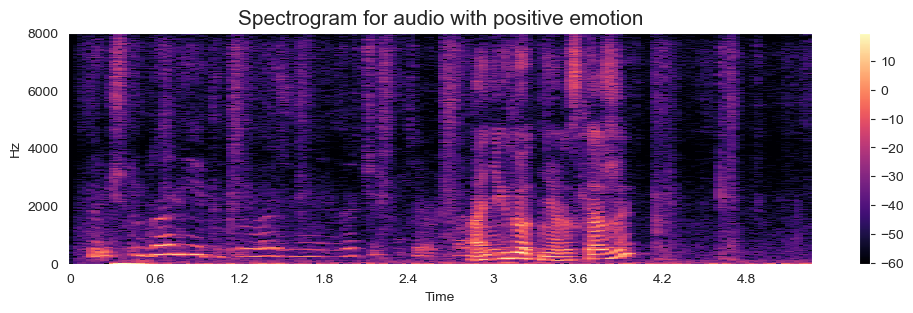

In [41]:
for index, row in data_5.iterrows():
    emotion = row['speaker_emo'] 
    audio_path = AUDIO_DIR + row['hash_id'] + ".wav"
    audio_data, sr = librosa.load(audio_path, sr=None)
    create_audio_display(audio_path)
    create_waveplot(audio_data, sr, emotion)
    create_spectrogram(audio_data, sr, emotion)
